In [77]:
import h2o

In [78]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 6 mins
H2O cluster timezone:,America/Santiago
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months and 20 days !!!
H2O cluster name:,H2O_from_python_maravenag_7jwpzr
H2O cluster total nodes:,1
H2O cluster free memory:,3.278 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [79]:
train = h2o.upload_file("data/train.csv", destination_frame="train")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [80]:
train = train.drop("PassengerId")
train = train.drop("Name")
train = train.drop("Cabin")
train = train.drop("Ticket")

In [81]:
train.head()

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.25,S
1,1,female,38,1,0,71.2833,C
1,3,female,26,0,0,7.925,S
1,1,female,35,1,0,53.1,S
0,3,male,35,0,0,8.05,S
0,3,male,nan,0,0,8.4583,Q
0,1,male,54,0,0,51.8625,S
0,3,male,2,3,1,21.075,S
1,3,female,27,0,2,11.1333,S
1,2,female,14,1,0,30.0708,C


In [82]:
train['Survived'] = train['Survived'].asfactor()
train['Pclass'] = train['Pclass'].asfactor()
train['Sex'] = train['Sex'].asfactor()
train['Embarked'] = train['Embarked'].asfactor()

In [83]:
train, test = train.split_frame(ratios=[0.7])

In [84]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [87]:
model = H2OGradientBoostingEstimator(nfolds=5)

In [88]:
train_cols = [x for x in train.col_names if x not in ['Survived']]

In [89]:
model.train(x=train_cols,y="Survived",training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


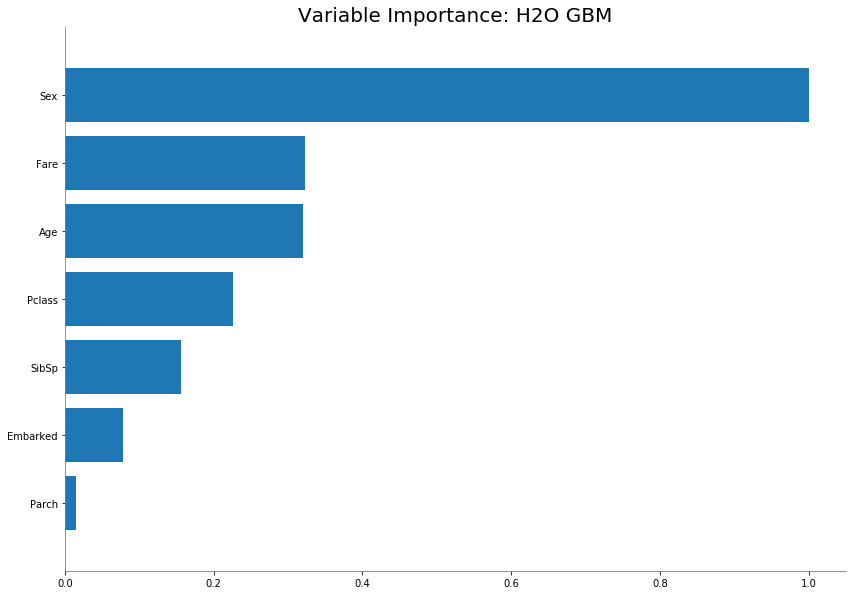

In [90]:
model.varimp_plot()

In [91]:
import json

In [92]:
variables = list(map(lambda x: {
    'variable_name':x[0],
    'relative_importance':x[1],
    'scaled_importances':x[2],
    'percentage':x[3]
}, model.varimp()))

In [101]:
gains_lift = json.loads(model.gains_lift(xval=True).as_data_frame().to_json(orient="table",index=False))['data']

In [95]:
training_metrics = {
    "MSE": model.model_performance().mse(),
    "RMSE": model.model_performance().rmse(),
    "LogLoss": model.model_performance().logloss(),
    "Mean Per-Class Error": model.model_performance().mean_per_class_error(),
    "AUC":model.model_performance().auc(),
    "PR_AUC": model.model_performance().pr_auc(),
    "Gini": model.model_performance().gini()
}

In [96]:
xval_metrics = {
    "MSE": model.model_performance(xval=True).mse(),
    "RMSE": model.model_performance(xval=True).rmse(),
    "LogLoss": model.model_performance(xval=True).logloss(),
    "Mean Per-Class Error": model.model_performance(xval=True).mean_per_class_error(),
    "AUC":model.model_performance(xval=True).auc(),
    "PR_AUC": model.model_performance(xval=True).pr_auc(),
    "Gini": model.model_performance(xval=True).gini()
}

In [127]:
def generate_report(model):
    try:
        validation_metrics = {
                    "MSE": model.model_performance(valid=True).mse(),
                    "RMSE": model.model_performance(valid=True).rmse(),
                    "LogLoss": model.model_performance(valid=True).logloss(),
                    "Mean Per-Class Error": model.model_performance(valid=True).mean_per_class_error(),
                    "AUC":model.model_performance(valid=True).auc(),
                    "PR_AUC": model.model_performance(valid=True).pr_auc(),
                    "Gini": model.model_performance(valid=True).gini()
                }
    except Exception as e:
        validation_metrics = {}

    try:
        xval_metrics= {
                    "MSE": model.model_performance(xval=True).mse(),
                    "RMSE": model.model_performance(xval=True).rmse(),
                    "LogLoss": model.model_performance(xval=True).logloss(),
                    "Mean Per-Class Error": model.model_performance(xval=True).mean_per_class_error(),
                    "AUC":model.model_performance(xval=True).auc(),
                    "PR_AUC": model.model_performance(xval=True).pr_auc(),
                    "Gini": model.model_performance(xval=True).gini() 
        }
    except Exception as e:
        xval_metrics = {}
    
    return {
        'model_name': model.model_id,
        'variables_importance':list(map(lambda x: {
                                    'variable_name':x[0],
                                    'relative_importance':x[1],
                                    'scaled_importances':x[2],
                                    'percentage':x[3]
                                }, model.varimp())),
        'gains_lift': json.loads(model.gains_lift(xval=True).as_data_frame().to_json(orient="table",index=False))['data'],
        'training_metrics':{
                            "MSE": model.model_performance().mse(),
                            "RMSE": model.model_performance().rmse(),
                            "LogLoss": model.model_performance().logloss(),
                            "Mean Per-Class Error": model.model_performance().mean_per_class_error(),
                            "AUC":model.model_performance().auc(),
                            "PR_AUC": model.model_performance().pr_auc(),
                            "Gini": model.model_performance().gini()
                        },
        'validation_metrics':validation_metrics,
        'xval_metrics':xval_metrics
    }

In [128]:
generate_report(model)

{'model_name': 'GBM_model_python_1558025548122_104',
 'variables_importance': [{'variable_name': 'Sex',
   'relative_importance': 247.19891357421875,
   'scaled_importances': 1.0,
   'percentage': 0.472193845266491},
  {'variable_name': 'Fare',
   'relative_importance': 79.73954772949219,
   'scaled_importances': 0.3225724036426692,
   'percentage': 0.15231670365288663},
  {'variable_name': 'Age',
   'relative_importance': 79.13831329345703,
   'scaled_importances': 0.32014021481407773,
   'percentage': 0.15116823905749982},
  {'variable_name': 'Pclass',
   'relative_importance': 56.02534484863281,
   'scaled_importances': 0.22664074060265568,
   'percentage': 0.10701836279921333},
  {'variable_name': 'SibSp',
   'relative_importance': 38.44557189941406,
   'scaled_importances': 0.15552484168936773,
   'percentage': 0.07343787303176481},
  {'variable_name': 'Embarked',
   'relative_importance': 19.406673431396484,
   'scaled_importances': 0.07850630551242227,
   'percentage': 0.0370701